In [18]:
import joblib as jb
import numpy as np
import pandas as pd
import shap
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
import lightgbm
import sklearn
import copy

plt.rcdefaults()

# Package versions
print("Joblib version:", jb.__version__)
print("NumPy version:", np.__version__)
print("pandas version:", pd.__version__)
print("scikit-learn version:", sklearn.__version__)
print("lightgbm version:", lightgbm.__version__)
print("shap version:", shap.__version__)

Joblib version: 1.4.2
NumPy version: 1.26.4
pandas version: 2.2.3
scikit-learn version: 1.4.1.post1
lightgbm version: 4.5.0
shap version: 0.46.0


In [19]:
# Loading data
data_per_year = jb.load("data_per_year.pkl")

In [20]:
# Preprocessing step for historic data from the clinic
# 1) No-show statistics
no_show_rate_cols = ['no_show_rate_last_1_day_in_MR',
       'median_no_show_rate_last_7_days_in_MR',
       'median_no_show_rate_last_30_days_in_MR',
       'quantile25_no_show_rate_last_7_days_in_MR',
       'quantile25_no_show_rate_last_30_days_in_MR',
       'quantile75_no_show_rate_last_7_days_in_MR',
       'quantile75_no_show_rate_last_30_days_in_MR',
       'mean_no_show_rate_last_7_days_in_MR',
       'mean_no_show_rate_last_30_days_in_MR',
       'min_no_show_rate_last_7_days_in_MR',
       'min_no_show_rate_last_30_days_in_MR',
       'max_no_show_rate_last_7_days_in_MR',
       'max_no_show_rate_last_30_days_in_MR',
       'std_no_show_rate_last_7_days_in_MR',
       'std_no_show_rate_last_30_days_in_MR',
       'no_show_rate_last_1_day_clinic_wide',
       'median_no_show_rate_last_7_days_clinic_wide',
       'median_no_show_rate_last_30_days_clinic_wide',
       'quantile25_no_show_rate_last_7_days_clinic_wide',
       'quantile25_no_show_rate_last_30_days_clinic_wide',
       'quantile75_no_show_rate_last_7_days_clinic_wide',
       'quantile75_no_show_rate_last_30_days_clinic_wide',
       'mean_no_show_rate_last_7_days_clinic_wide',
       'mean_no_show_rate_last_30_days_clinic_wide',
       'min_no_show_rate_last_7_days_clinic_wide',
       'min_no_show_rate_last_30_days_clinic_wide',
       'max_no_show_rate_last_7_days_clinic_wide',
       'max_no_show_rate_last_30_days_clinic_wide',
       'std_no_show_rate_last_7_days_clinic_wide',
       'std_no_show_rate_last_30_days_clinic_wide']

# 2) Demand statistics
demand_cols = ['demand_last_1_day_MR', 'median_demand_last_7_days_MR',
       'median_demand_last_30_days_MR', 'quantile25_demand_last_7_days_MR',
       'quantile25_demand_last_30_days_MR', 'quantile75_demand_last_7_days_MR',
       'quantile75_demand_last_30_days_MR', 'mean_demand_last_7_days_MR',
       'mean_demand_last_30_days_MR', 'min_demand_last_7_days_MR',
       'min_demand_last_30_days_MR', 'max_demand_last_7_days_MR',
       'max_demand_last_30_days_MR', 'std_demand_last_7_days_MR',
       'std_demand_last_30_days_MR', 'demand_last_1_day_clinic_wide',
       'median_demand_last_7_days_clinic_wide',
       'median_demand_last_30_days_clinic_wide',
       'quantile25_demand_last_7_days_clinic_wide',
       'quantile25_demand_last_30_days_clinic_wide',
       'quantile75_demand_last_7_days_clinic_wide',
       'quantile75_demand_last_30_days_clinic_wide',
       'mean_demand_last_7_days_clinic_wide',
       'mean_demand_last_30_days_clinic_wide',
       'min_demand_last_7_days_clinic_wide',
       'min_demand_last_30_days_clinic_wide',
       'max_demand_last_7_days_clinic_wide',
       'max_demand_last_30_days_clinic_wide',
       'std_demand_last_7_days_clinic_wide',
       'std_demand_last_30_days_clinic_wide']

# Corresponding PCA objects
pca_no_show = PCA(whiten=True, n_components=0.95)
pca_demand  = PCA(whiten=True, n_components=0.95)

# Preparing transformers list
transformers = [
    ("sex", SimpleImputer(strategy="most_frequent"), ["sex"]), # Just need to impute missing values
    ("PCA_no_show", pca_no_show, no_show_rate_cols),
    ("PCA_demand", pca_demand, demand_cols),
    ("numerical_no_indicator", Pipeline([
        ("standardize", StandardScaler()),
        ("impute", SimpleImputer(strategy="median")) # simple_imputer without missing indicator
    ]), ["age", "distance_to_clinic"]),
    ("numerical", Pipeline([
        ("standardize", StandardScaler()),
        ("impute", SimpleImputer(strategy="median", add_indicator=True)) # simple_imputer with missing indicator
    ]), ["waiting_time", "no_show_history", "today_demand_clinic_wide", "today_demand_MR"])
]

# Initializing ColumnTransformer
col_transformer = ColumnTransformer(transformers, remainder="passthrough")

# Wrapper to automatically create DataFrames after transforming data
class DFConverter(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, cat_cols):
        self.transformer = transformer
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        # Get feature names
        self.feature_names_ = list(map(lambda c: c.split("__")[-1] if "pca" not in c else c, self.transformer.get_feature_names_out()))
        self.feature_names_ = [f"PC-{feature[-1]} (past no-show rate)"\
                               if ("PCA" in feature) and ("no_show" in feature)\
                               else feature\
                               for feature in self.feature_names_]
        self.feature_names_ = [f"PC-{feature[-1]} (past demand)"\
                               if ("PCA" in feature) and ("demand" in feature)\
                               else feature\
                               for feature in self.feature_names_]
        self.feature_names_ = [f"first time in clinic"\
                               if ("missingindicator" in feature)\
                               else feature\
                               for feature in self.feature_names_]
        self.feature_names_ = [feature.replace("_", " ") for feature in self.feature_names_]
        return self

    def transform(self, X):
        arr = self.transformer.transform(X)
        df = pd.DataFrame(arr, columns=self.feature_names_, index=X.index)
        # Converting data to categorical type
        for c in df.columns:
            if c in self.cat_cols:
                df[c] = df[c].astype("category")
            else:
                df[c] = df[c].astype("float")
        return df

# All categorical columns
cat_cols = ["sex", 'healthcare plan', 'procedure', 'day of week', 'month', 'hour']

col_transformer = DFConverter(col_transformer, cat_cols)

In [21]:
# Classifier with the best set of hyperparameters
clf = LGBMClassifier(n_jobs=-1, verbosity=-1, n_estimators=3000, max_depth=63, colsample_bytree=0.7886372708925217,
                    scale_pos_weight=7.472410910017989, learning_rate=0.0007589929361363828, reg_alpha=0.0011885229743602958,
                    reg_lambda=0.7041794245156696)

# Final pipeline, including classifier
model_pipe = Pipeline([
    ("col_transformer", col_transformer),
    ("clf", clf)
])

In [22]:
def get_train_test(data_dict, test_year, initial_year):
    # Concatenate all data from initial_year up to the year before test_year
    train_years = list(range(initial_year, test_year))
    df_train = pd.concat([data_dict[year] for year in train_years])
    df_test = data_dict[test_year]

    # Separate features and target
    X_train = df_train.drop(columns=["no_show"]).reset_index(drop=True)
    y_train = df_train["no_show"].values
    X_test = df_test.drop(columns=["no_show"])
    y_test = df_test["no_show"].values

    # Return weight equal to number of training folds
    return X_train, y_train, X_test, y_test, len(train_years)

In [23]:
# Testing data: 2023
X_train, y_train, X_test, y_test, _ = get_train_test(data_per_year, 2023, 2015)

# Fitting model
model_pipe.fit(X_train, y_train)

# Predicting
y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.37) * 1.0 # Best threshold = 0.37

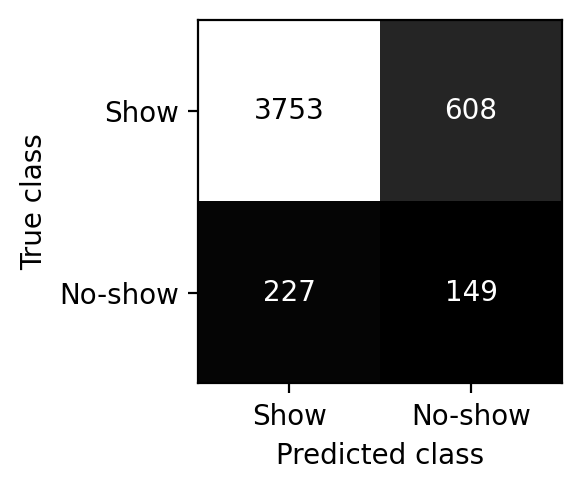

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Show', 'No-show']
)
fig, ax = plt.subplots(figsize=(3, 3))
disp.plot(ax=ax, cmap='Grays_r', colorbar=False)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=400)
plt.show()

In [25]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9430    0.8606    0.8999      4361
         1.0     0.1968    0.3963    0.2630       376

    accuracy                         0.8237      4737
   macro avg     0.5699    0.6284    0.5815      4737
weighted avg     0.8837    0.8237    0.8493      4737



In [26]:
# FB-score
recall_precision_ratio = 1.5
print(fbeta_score(y_test, y_pred, beta=recall_precision_ratio))

0.3020898315658141


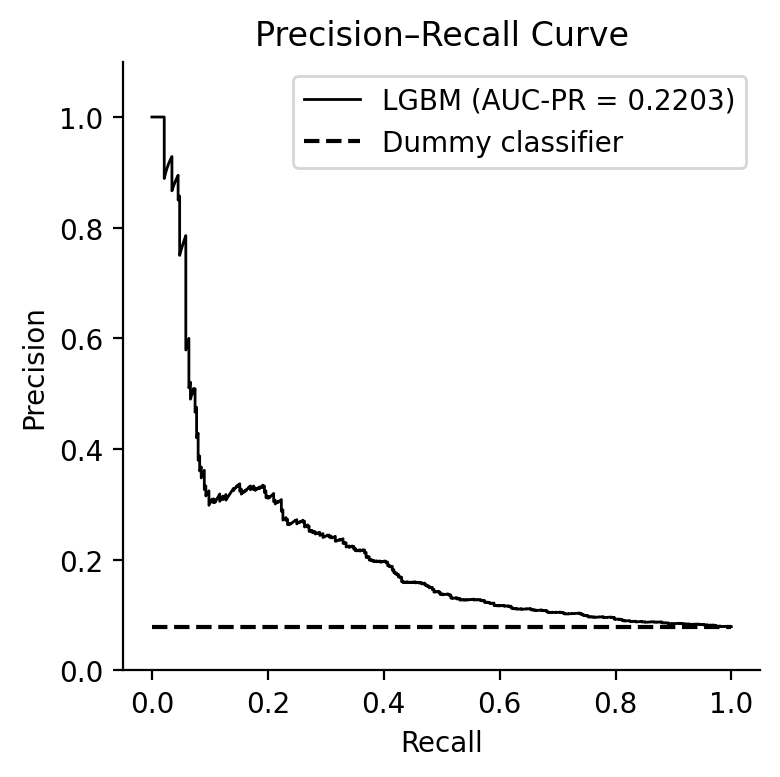

In [27]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)
dummy = y_test.mean()
plt.figure(figsize=(4, 4))
plt.plot(recall, precision, lw=1, color="black", 
         label=f"LGBM (AUC-PR = {ap:.4f})")
plt.hlines(dummy, 0, 1, linestyle="--", color="black", 
           label="Dummy classifier")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig("pr_curve.png", dpi=400)
plt.show()

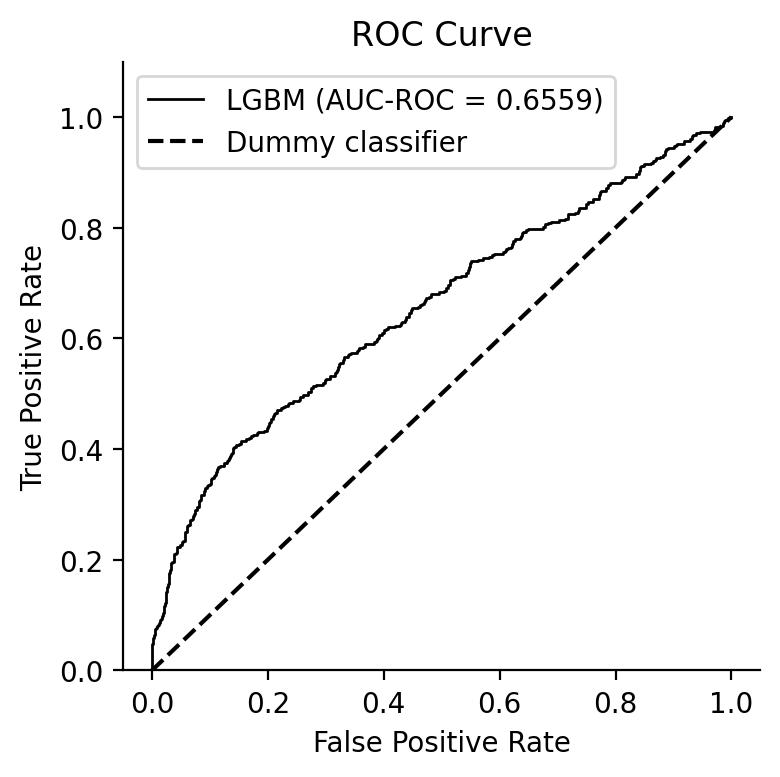

In [28]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, lw=1, color="black", label=f"LGBM (AUC-ROC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Dummy classifier", color="black")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=400)
plt.show()

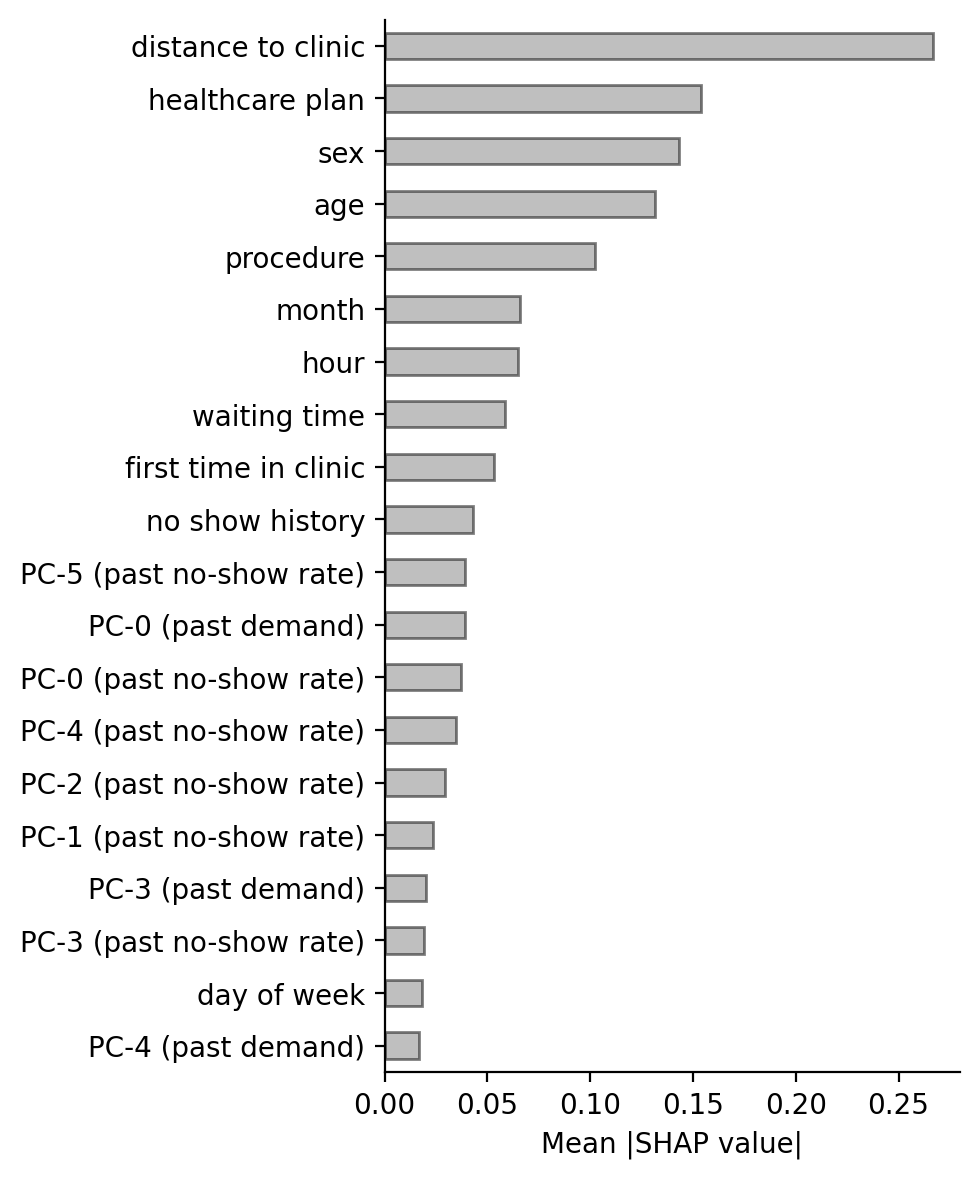

In [29]:
# Pre-transforming data, so we can calculate shap_values
X_train_transformed = model_pipe.named_steps["col_transformer"].transform(X_train)
explainer = shap.TreeExplainer(model_pipe.named_steps["clf"].booster_)
shap_values = explainer.shap_values(X_train_transformed)

# Calculating the mean|shap value| for each feature in top 20
mean_abs = np.abs(shap_values).mean(axis=0)
imp = pd.Series(mean_abs, index=X_train_transformed.columns)
imp = imp.sort_values()
imp.tail(20).plot(kind="barh", figsize=(5,6), color="gray", alpha=.5, edgecolor="black")
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("mean_abs_shap.png", dpi=400)
plt.show()

In [30]:
# Pre-transforming test data
X_test_transformed = model_pipe.named_steps["col_transformer"].transform(X_test)
explainer = shap.TreeExplainer(model_pipe.named_steps["clf"].booster_)
shap_values = explainer.shap_values(X_test_transformed)

# Deep copying col_transformer, so we can turn off standard scaler for the following plots
ct = copy.deepcopy(model_pipe.named_steps["col_transformer"])
ct.transformer.named_transformers_['numerical_no_indicator'].set_params(standardize='passthrough')  
ct.transformer.named_transformers_['numerical'].set_params(standardize='passthrough')
X_test_not_transformed = ct.transform(X_test)

import shap.plots.colors as sc
import matplotlib.colors as mcolors

# Override SHAP's default colors:
sc.red_rgb  = mcolors.to_rgb("black")
sc.blue_rgb = mcolors.to_rgb("gray")
sc.red_hex  = "#000000"
sc.blue_hex = "#808080"

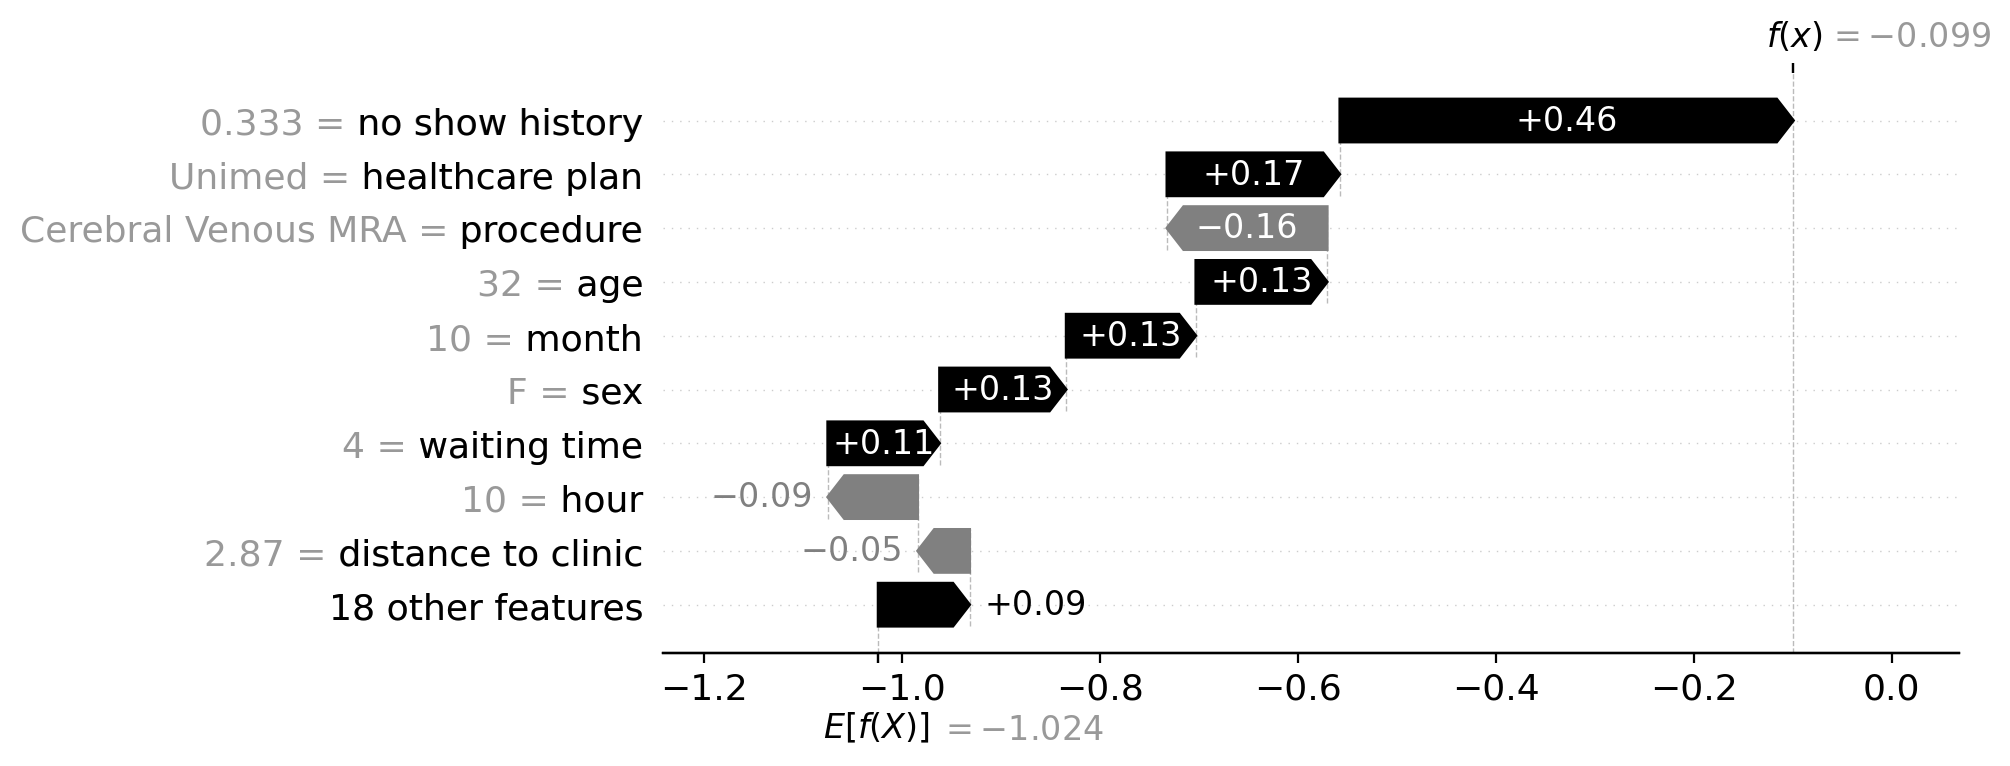

In [31]:
# "No-show" example with shap values
idx = 93
ax = shap.plots.waterfall(
        shap.Explanation(values=shap_values[((y_test == y_pred) * (y_test == 1.0)).astype(bool)][idx],
                         base_values=explainer.expected_value,
                         data=X_test_not_transformed.iloc[((y_test == y_pred) * (y_test == 1.0)).astype(bool)].iloc[idx],
                         feature_names=X_test_transformed.columns),
        show=False
)
fig = ax.figure
fig.set_size_inches(10, 4)
plt.tight_layout()
plt.savefig("no_show_example.png", dpi=400)
plt.show()

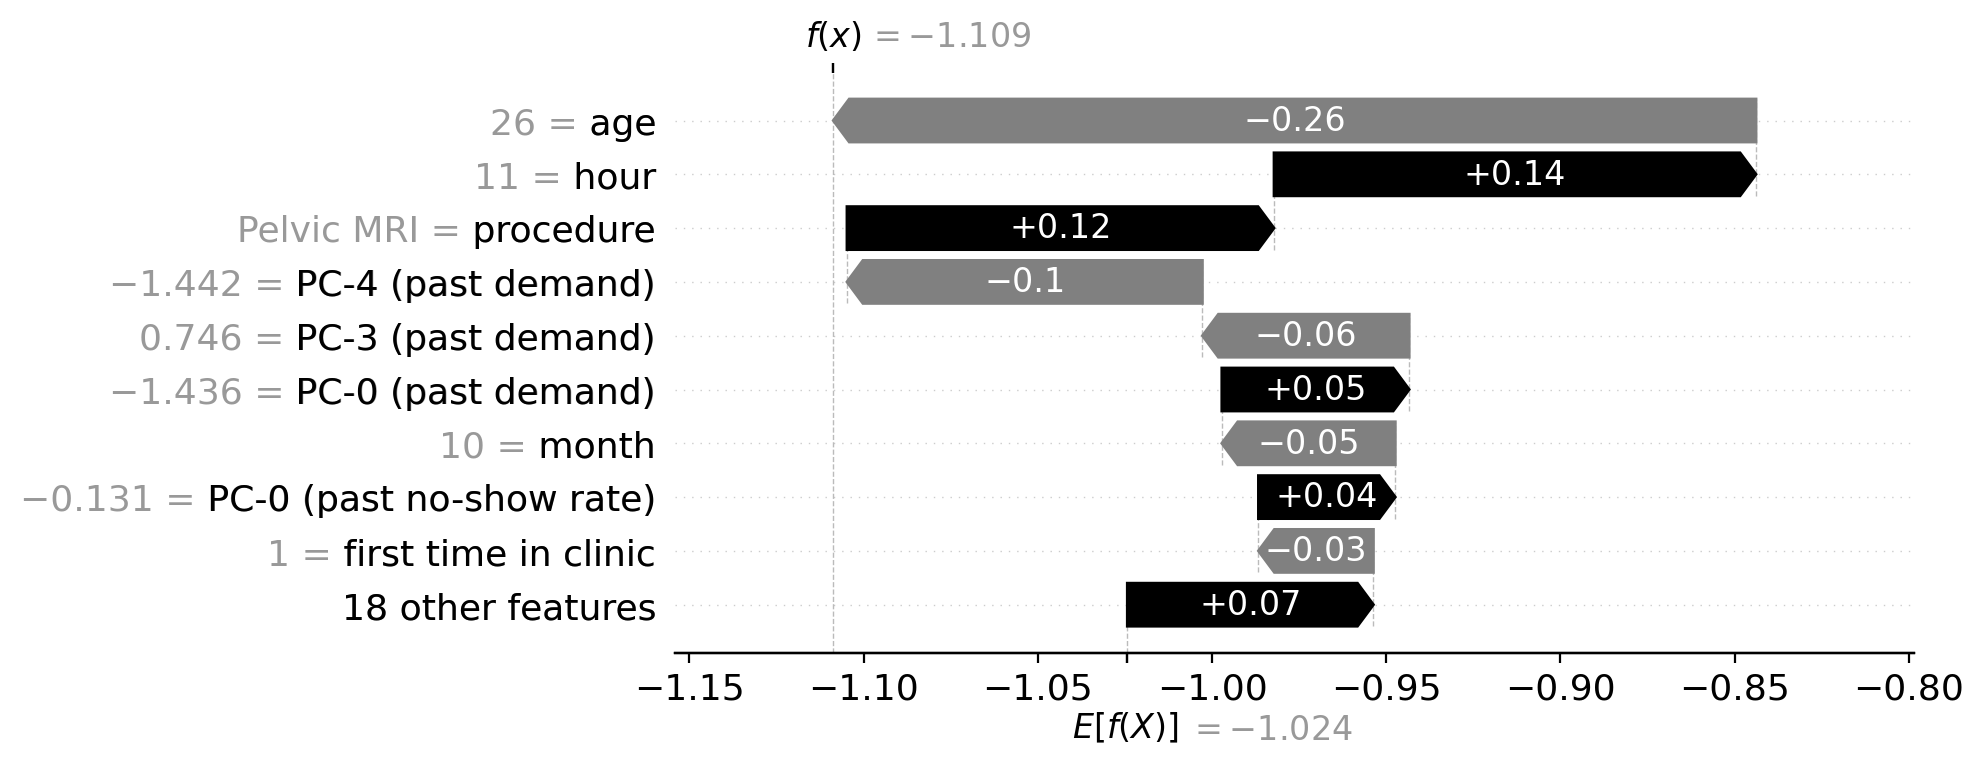

In [32]:
# "Show" example with shap values
idx = 106
ax = shap.plots.waterfall(
        shap.Explanation(values=shap_values[((y_test == y_pred) * (y_test == 0.0)).astype(bool)][idx],
                         base_values=explainer.expected_value,
                         data=X_test_not_transformed.iloc[((y_test == y_pred) * (y_test == 1.0)).astype(bool)].iloc[idx],
                         feature_names=X_test_transformed.columns),
        show=False
)
fig = ax.figure
fig.set_size_inches(10, 4)
plt.tight_layout()
plt.savefig("show_example.png", dpi=400)
plt.show()